In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

disp = pd.read_feather("disp.feather")
compet = pd.read_feather("compet.feather")

print("disp:", disp.shape)
print("compet:", compet.shape)

disp.head()



disp: (4380, 76)
compet: (733, 75)


,salida,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,...,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
0,12384900.0,low,0.0,0.0,0.000000,0.000000,None,low,251.901758,low,...,0.0,high,high,high,260.522389,NaN,low,49.000000,107.181818,73.545455
1,11908500.0,low,0.0,0.0,0.017273,0.139091,blue,medium,271.982095,medium,...,0.0,medium,medium,medium,232.871098,NaN,low,35.545455,72.454545,NaN
2,12470700.0,low,0.0,0.0,0.000000,0.000000,red,low,217.133093,low,...,0.0,medium,medium,medium,246.802193,NaN,low,50.181818,110.727273,NaN
3,12725400.0,low,0.0,0.0,0.000000,0.000000,blue,low,226.493584,low,...,0.0,medium,medium,medium,250.140133,NaN,low,49.909091,111.727273,77.272727
4,10894800.0,low,0.0,0.0,0.000000,0.000000,red,low,249.123549,medium,...,0.0,medium,medium,medium,244.200684,NaN,low,48.090909,106.090909,NaN


In [2]:
# PASO 2: separar variables y hacer particiones temporales

TARGET_COL = "salida"

X_all = disp.drop(columns=[TARGET_COL])
y_all = disp[TARGET_COL].copy()

print("Nº filas:", len(disp))
print("Nº atributos (sin salida):", X_all.shape[1])

# asumimos 12 años * 365 días = 4380 filas
days_per_year = 365
idx_6y = 6 * days_per_year
idx_9y = 9 * days_per_year

# 9 primeros años (para model selection), 3 últimos años (holdout final)
X_9y = X_all.iloc[:idx_9y].copy()
y_9y = y_all.iloc[:idx_9y].copy()

X_holdout_3y = X_all.iloc[idx_9y:].copy()
y_holdout_3y = y_all.iloc[idx_9y:].copy()

# dentro de los 9 primeros: 6 años train, 3 años validación
X_train_6y = X_9y.iloc[:idx_6y].copy()
y_train_6y = y_9y.iloc[:idx_6y].copy()

X_val_3y = X_9y.iloc[idx_6y:].copy()
y_val_3y = y_9y.iloc[idx_6y:].copy()

print("Train 6 años:", X_train_6y.shape)
print("Validación 3 años:", X_val_3y.shape)
print("Holdout final 3 años:", X_holdout_3y.shape)


Nº filas: 4380
Nº atributos (sin salida): 75
Train 6 años: (2190, 75)
Validación 3 años: (1095, 75)
Holdout final 3 años: (1095, 75)


In [3]:
# PASO 3: tipos de variables y NAs

num_cols = X_all.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_all.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Numéricas:", len(num_cols))
print("Categóricas:", len(cat_cols))

# porcentaje de NA por columna
na_ratio = X_all.isna().mean().sort_values(ascending=False)
print("\nTop columnas con más NA:")
print(na_ratio.head(10))

# columnas con MUCHOS NA (por ejemplo > 80%)
high_na_cols = na_ratio[na_ratio > 0.8].index.tolist()
print("\nColumnas con >80% NA:", list(high_na_cols))

def drop_high_na(df):
    cols = [c for c in high_na_cols if c in df.columns]
    return df.drop(columns=cols)

# aplicamos esta limpieza a todos los conjuntos
X_train_6y_clean = drop_high_na(X_train_6y)
X_val_3y_clean = drop_high_na(X_val_3y)
X_9y_clean = drop_high_na(X_9y)
X_holdout_3y_clean = drop_high_na(X_holdout_3y)
compet_clean = drop_high_na(compet)

num_cols_clean = X_train_6y_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_clean = X_train_6y_clean.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("\nTras borrar columnas con muchos NA:")
print("Numéricas limpias:", len(num_cols_clean))
print("Categóricas limpias:", len(cat_cols_clean))


Numéricas: 45
Categóricas: 30

Top columnas con más NA:
pwat_ea3_1    0.920091
uswrf_s1_1    0.889954
apcp_sf3_1    0.200000
pres_ms2_1    0.150000
tcdc_ea3_1    0.150000
dlwrf_s5_1    0.150000
tmp_sfc3_1    0.150000
tcdc_ea5_1    0.139954
tmax_2m5_1    0.139954
tmp_sfc5_1    0.139954
dtype: float64

Columnas con >80% NA: ['pwat_ea3_1', 'uswrf_s1_1']

Tras borrar columnas con muchos NA:
Numéricas limpias: 43
Categóricas limpias: 30


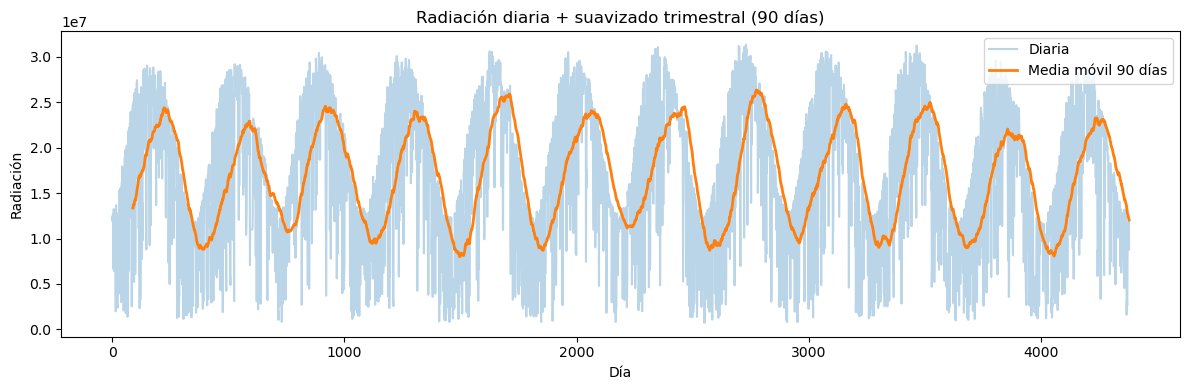

In [4]:
# EDA - Suavizado trimestral (90 días)

salida_suave_90 = y_all.rolling(window=90).mean()

plt.figure(figsize=(12,4))
plt.plot(y_all, alpha=0.3, label="Diaria")
plt.plot(salida_suave_90, linewidth=2, label="Media móvil 90 días")
plt.title("Radiación diaria + suavizado trimestral (90 días)")
plt.xlabel("Día")
plt.ylabel("Radiación")
plt.legend()
plt.tight_layout()
plt.show()


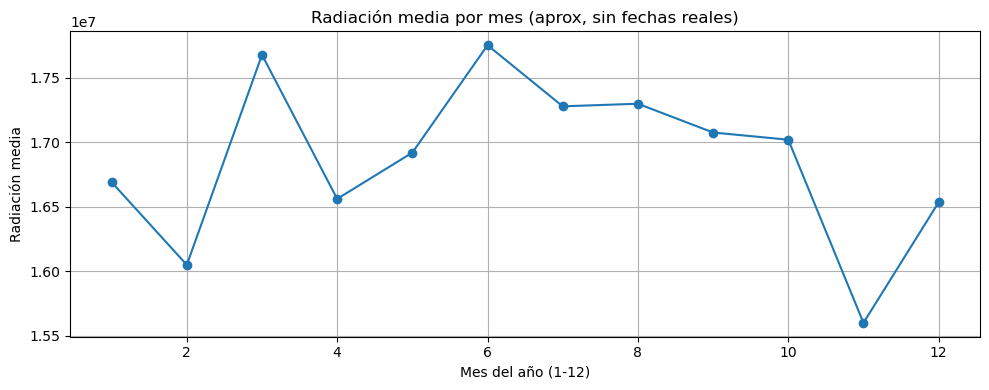

In [5]:
# EDA - Promedio mensual de 'salida' sin usar fechas reales

# Creamos índices de mes (12 años * 12 meses)
meses = np.repeat(np.arange(1, 13), 365)[:len(y_all)]

salida_mensual = pd.DataFrame({
    "mes": meses,
    "salida": y_all.values
}).groupby("mes").mean()

plt.figure(figsize=(10,4))
plt.plot(salida_mensual.index, salida_mensual["salida"], marker="o")
plt.title("Radiación media por mes (aprox, sin fechas reales)")
plt.xlabel("Mes del año (1-12)")
plt.ylabel("Radiación media")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\gutie\AppData\Local\Temp\ipykernel_28464\344939228.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  salida_mensual = pd.Series(y_all.values, index=fechas).resample("M").mean()


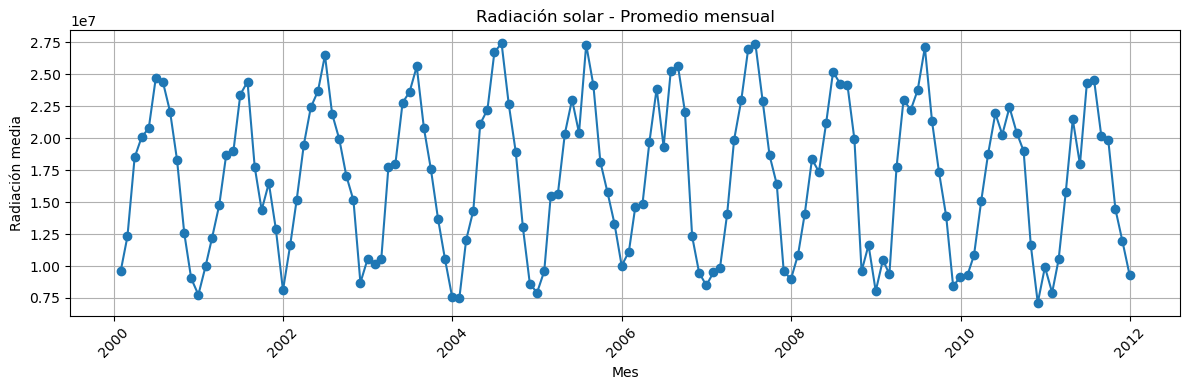

In [6]:
# EDA - Radiación mensual con nombres de meses (sin modificar dataset)

fechas = pd.date_range("2000-01-01", periods=len(y_all), freq="D")
salida_mensual = pd.Series(y_all.values, index=fechas).resample("M").mean()

plt.figure(figsize=(12,4))
plt.plot(salida_mensual.index, salida_mensual.values, marker="o")
plt.title("Radiación solar - Promedio mensual")
plt.xlabel("Mes")
plt.ylabel("Radiación media")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


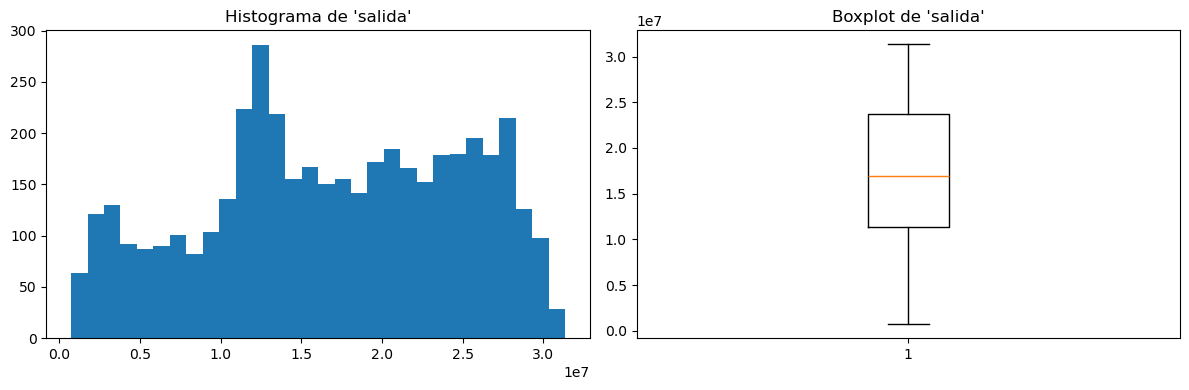

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_all, bins=30)
axes[0].set_title("Histograma de 'salida'")

axes[1].boxplot(y_all)
axes[1].set_title("Boxplot de 'salida'")

plt.tight_layout()
plt.show()


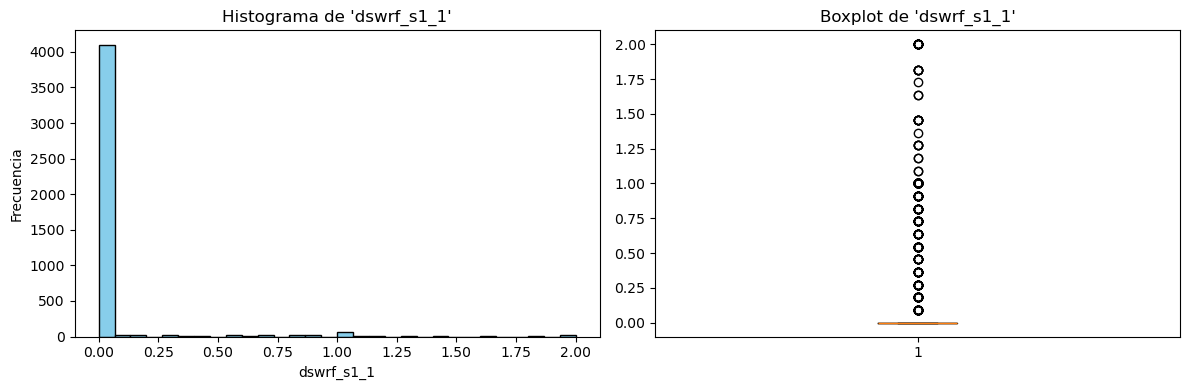

In [8]:
# EDA - Distribución de dswrf_s1_1 (radiación descendente)

col = "dswrf_s1_1"
serie = disp[col].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma
axes[0].hist(serie, bins=30, color="skyblue", edgecolor="black")
axes[0].set_title(f"Histograma de '{col}'")
axes[0].set_xlabel(col)
axes[0].set_ylabel("Frecuencia")

# Boxplot
axes[1].boxplot(serie)
axes[1].set_title(f"Boxplot de '{col}'")

plt.tight_layout()
plt.show()


In [9]:
# Sesgo de todas las variables numéricas
skew_df = disp[num_cols_clean].skew().sort_values(ascending=False)
skew_df


apcp_sf2_1    9.337961
apcp_sf3_1    9.001777
apcp_sf4_1    8.293989
apcp_sf5_1    6.909561
tcolc_e5_1    5.635290
dswrf_s1_1    5.549383
tcdc_ea2_1    5.364481
tcolc_e1_1    4.896597
tcdc_ea1_1    4.889635
pwat_ea2_1    0.476913
pwat_ea4_1    0.419226
pres_ms1_1    0.372095
pres_ms3_1    0.370232
pres_ms2_1    0.364091
pres_ms4_1    0.320256
spfh_2m1_1    0.315210
dswrf_s2_1    0.281255
spfh_2m2_1    0.210469
spfh_2m4_1    0.138822
spfh_2m5_1    0.093178
tmin_2m2_1    0.000000
ulwrf_t1_1    0.000000
spfh_2m3_1    0.000000
tcolc_e3_1    0.000000
tmin_2m4_1    0.000000
tmp_2m_3_1    0.000000
ulwrf_s4_1   -0.101418
ulwrf_s5_1   -0.102542
ulwrf_s2_1   -0.146679
dlwrf_s3_1   -0.197134
dswrf_s3_1   -0.200256
tmin_2m5_1   -0.251690
tmp_sfc5_1   -0.258573
tmp_sfc3_1   -0.264054
tmp_2m_5_1   -0.271015
tmp_2m_2_1   -0.307751
tmp_sfc1_1   -0.308001
tmin_2m3_1   -0.316238
uswrf_s4_1   -0.324857
tmax_2m5_1   -0.340992
uswrf_s3_1   -0.352794
uswrf_s5_1   -0.387564
ulwrf_t5_1   -1.054320
dtype: floa

In [10]:
def analizar_variable_numerica(col):
    serie = disp[col]
    print(f"=== {col} ===")
    print(f"NAs: {serie.isna().sum()}  ({serie.isna().mean()*100:.2f}% )")
    print(f"Media:   {serie.mean():.4f}")
    print(f"Mediana: {serie.median():.4f}")
    print(f"Desv.Std:{serie.std():.4f}")
    print(f"Skew (sesgo): {serie.skew():.4f}")
    
    skew = abs(serie.skew())
    if skew > 1:
        print("→ Distribución muy sesgada → imputación recomendada: MEDIANA")
    else:
        print("→ Distribución simétrica → imputación recomendada: MEDIA")
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].hist(serie.dropna(), bins=30)
    axes[0].set_title(f"Histograma de {col}")
    
    axes[1].boxplot(serie.dropna())
    axes[1].set_title(f"Boxplot de {col}")
    
    plt.tight_layout()
    plt.show()


In [11]:
na_percent = disp.isna().mean().sort_values(ascending=False)


In [12]:
skewness = disp.select_dtypes(include=["float", "int"]).skew().sort_values(ascending=False)


In [13]:
unique_counts = disp.nunique().sort_values()
constant_vars = unique_counts[unique_counts <= 2]


In [14]:
outlier_info = []

for col in num_cols_clean:
    serie = disp[col].dropna()
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = ((serie < lower) | (serie > upper)).sum()
    
    outlier_info.append({
        "variable": col,
        "outliers": n_outliers
    })

outliers_df = pd.DataFrame(outlier_info).sort_values("outliers", ascending=False)
outliers_df.head(15)


,variable,outliers
2,apcp_sf4_1,964
0,apcp_sf2_1,903
3,apcp_sf5_1,794
23,tcolc_e5_1,709
1,apcp_sf3_1,688
19,tcdc_ea1_1,633
21,tcolc_e1_1,632
20,tcdc_ea2_1,629
5,dswrf_s1_1,282
41,uswrf_s4_1,238


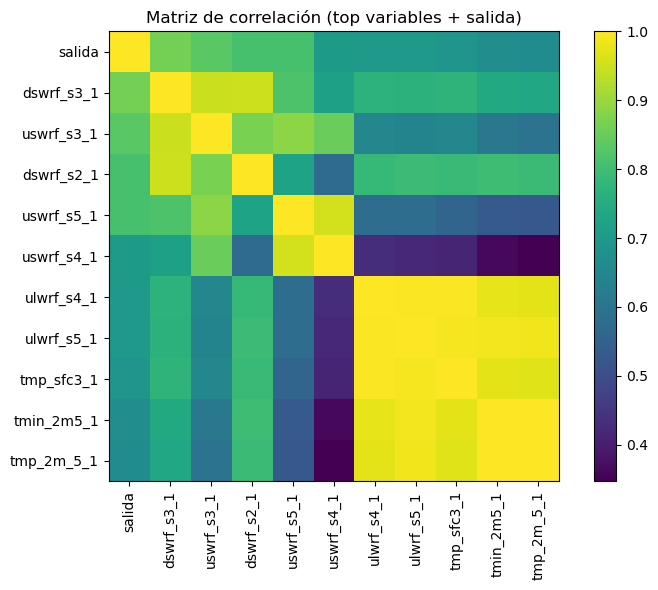

In [15]:
corr_with_y = disp[num_cols_clean + ["salida"]].corr()["salida"].sort_values(ascending=False)

top_vars = corr_with_y.abs().sort_values(ascending=False).head(11).index
corr_top = disp[top_vars].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_top, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(top_vars)), top_vars, rotation=90)
plt.yticks(range(len(top_vars)), top_vars)
plt.title("Matriz de correlación (top variables + salida)")
plt.tight_layout()
plt.show()


In [16]:
# =============================
# PREPROCESADO - PARTE 2
# Definición del preprocesado base
# =============================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold



print("Nº columnas numéricas limpias:", len(num_cols_clean))
print("Nº columnas categóricas limpias:", len(cat_cols_clean))

# 1) Pipeline para variables numéricas
numeric_pre_base = Pipeline(steps=[
    ("var", VarianceThreshold(threshold=0.0)),           # elimina columnas casi constantes
    ("imputer", SimpleImputer(strategy="mean")),         # imputación inicial (luego la afinaremos)
    ("scaler", StandardScaler())                         # escalado estándar (luego probaremos otros)
])

# 2) Pipeline para variables categóricas
categorical_pre_base = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # rellenar con la categoría más frecuente
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # one-hot para que los modelos puedan usarlas
])

# 3) ColumnTransformer que aplica cada cosa donde toca
preprocessor_base = ColumnTransformer(
    transformers=[
        ("num", numeric_pre_base, num_cols_clean),
        ("cat", categorical_pre_base, cat_cols_clean)
    ]
)

# 4) Comprobamos que el preprocesador se puede ajustar sin errores
preprocessor_base.fit(X_train_6y_clean)

X_train_6y_pre = preprocessor_base.transform(X_train_6y_clean)
X_val_3y_pre   = preprocessor_base.transform(X_val_3y_clean)

print("Shape X_train después de preprocesar:", X_train_6y_pre.shape)
print("Shape X_val   después de preprocesar:", X_val_3y_pre.shape)


Nº columnas numéricas limpias: 43
Nº columnas categóricas limpias: 30
Shape X_train después de preprocesar: (2190, 130)
Shape X_val   después de preprocesar: (1095, 130)


In [17]:
from sklearn.feature_selection import VarianceThreshold


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler


In [19]:
# =============================
# PREPROCESADO - PARTE 3
# Búsqueda del mejor esquema de preprocesado usando KNN
# =============================

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

# 3.1: pipeline completo (preprocesado + modelo KNN)
pipe_knn = Pipeline(steps=[
    ("preprocessor", preprocessor_base),
    ("regressor", KNeighborsRegressor())
])

# 3.2: combinaciones a probar en el preprocesado

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler()
]

num_imputers = [
    SimpleImputer(strategy="mean"),
    SimpleImputer(strategy="median")
]

cat_imputers = [
    SimpleImputer(strategy="most_frequent"),
    SimpleImputer(strategy="constant", fill_value="missing")
]

param_grid_pre = {
    "preprocessor__num__imputer": num_imputers,
    "preprocessor__num__scaler": scalers,
    "preprocessor__cat__imputer": cat_imputers
}

# 3.3: validación temporal
tscv = TimeSeriesSplit(n_splits=3)

grid_pre = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_pre,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# Entrenamos solo con los 6 primeros años
grid_pre.fit(X_train_6y_clean, y_train_6y)

print("\n>> Mejor combinación de preprocesado encontrada:")
print(grid_pre.best_params_)
print(f"R2 medio CV (6 años): {grid_pre.best_score_:.4f}")

# 3.4: evaluamos esa mejor combinación en los 3 años de validación
best_model_pre = grid_pre.best_estimator_

y_val_pred = best_model_pre.predict(X_val_3y_clean)

r2_val = r2_score(y_val_3y, y_val_pred)
mae_val = mean_absolute_error(y_val_3y, y_val_pred)

print(f"\nR2 en validación (3 años): {r2_val:.4f}")
print(f"MAE en validación (3 años): {mae_val:.4f}")

# 3.5: nos guardamos SOLO el preprocesador final
preprocessor_final = best_model_pre.named_steps["preprocessor"]


Fitting 3 folds for each of 16 candidates, totalling 48 fits

>> Mejor combinación de preprocesado encontrada:
{'preprocessor__cat__imputer': SimpleImputer(strategy='most_frequent'), 'preprocessor__num__imputer': SimpleImputer(strategy='median'), 'preprocessor__num__scaler': StandardScaler()}
R2 medio CV (6 años): 0.7410

R2 en validación (3 años): 0.8094
MAE en validación (3 años): 2631986.6038


In [20]:
from sklearn import set_config

set_config(display="diagram")
pipe_knn


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('var',
                                                                   VarianceThreshold()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['apcp_sf2_1', 'apcp_sf3_1',
                                                   'apcp_sf4_1', 'apcp_sf5_1',
                                                   'dlwrf_s3_1', 'dswrf_s1_1',
                                                   'dswrf_s2_1', 'dswrf_s3_1',
                                                   'pres_ms1_1', 'pres_ms2_1',
                                                   'pres_ms3_1', 'pres_ms4_1',
                                                   'pwat_ea2_1', 'pwat_e...
                                                   'dswrf_s5_1', 'pres_ms5_1',
                                                   'pwat_ea1_1', 'pwat_ea5_1',
                                                   'tcdc_ea3_1', 'tcdc_ea4_1',
                                                   'tcdc_ea5_1', 'tcolc_e2_1',
                                                   'tcolc_e4_1', 'tmax_2m1_1',
                                                   'tmax_2m2_1', 'tmax_2m3_1',
                                                   'tmax_2m4_1', 'tmin_2m1_1',
                                                   'tmp_2m_1_1', 'tmp_2m_4_1',
                                                   'tmp_sfc2_1', 'tmp_sfc4_1',
                                                   'ulwrf_s1_1', 'ulwrf_s3_1',
                                                   'ulwrf_t2_1', 'ulwrf_t3_1',
                                                   'ulwrf_t4_1',
                                                   'uswrf_s2_1'])])),
                ('regressor', KNeighborsRegressor())])

In [21]:
import pandas as pd

results = pd.DataFrame(grid_pre.cv_results_)

results.head()
def get_name(obj):
    # obj es un SimpleImputer o un scaler; cogemos su clase
    return obj.__class__.__name__

results["num_imputer_name"] = results["param_preprocessor__num__imputer"].apply(get_name)
results["num_scaler_name"] = results["param_preprocessor__num__scaler"].apply(get_name)
results["cat_imputer_name"] = results["param_preprocessor__cat__imputer"].apply(get_name)

results[[
    "num_imputer_name", "num_scaler_name", "cat_imputer_name",
    "mean_test_score", "std_test_score"
]]


,num_imputer_name,num_scaler_name,cat_imputer_name,mean_test_score,std_test_score
0,SimpleImputer,StandardScaler,SimpleImputer,0.738407,0.055153
1,SimpleImputer,MinMaxScaler,SimpleImputer,0.727574,0.029562
2,SimpleImputer,MaxAbsScaler,SimpleImputer,0.732496,0.028722
3,SimpleImputer,RobustScaler,SimpleImputer,0.632894,0.060158
4,SimpleImputer,StandardScaler,SimpleImputer,0.740995,0.055292
5,SimpleImputer,MinMaxScaler,SimpleImputer,0.726710,0.029630
6,SimpleImputer,MaxAbsScaler,SimpleImputer,0.732689,0.028879
7,SimpleImputer,RobustScaler,SimpleImputer,0.567502,0.037979
8,SimpleImputer,StandardScaler,SimpleImputer,0.738407,0.055153
9,SimpleImputer,MinMaxScaler,SimpleImputer,0.727574,0.029562


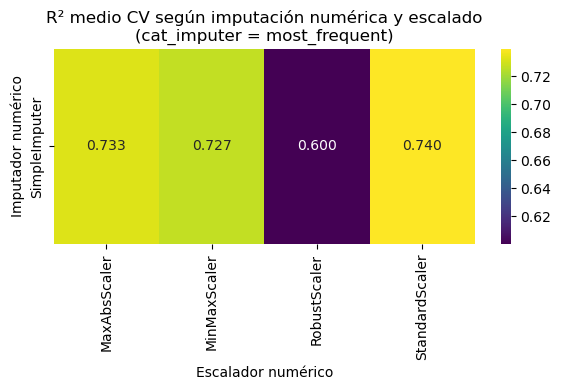

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nos quedamos, por ejemplo, con las filas donde cat_imputer = 'SimpleImputer' (most_frequent)
mask_mf = results["cat_imputer_name"] == "SimpleImputer"
res_mf = results[mask_mf]

pivot_mf = res_mf.pivot_table(
    index="num_imputer_name",
    columns="num_scaler_name",
    values="mean_test_score"
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_mf, annot=True, fmt=".3f", cmap="viridis")
plt.title("R² medio CV según imputación numérica y escalado\n(cat_imputer = most_frequent)")
plt.ylabel("Imputador numérico")
plt.xlabel("Escalador numérico")
plt.tight_layout()
plt.show()


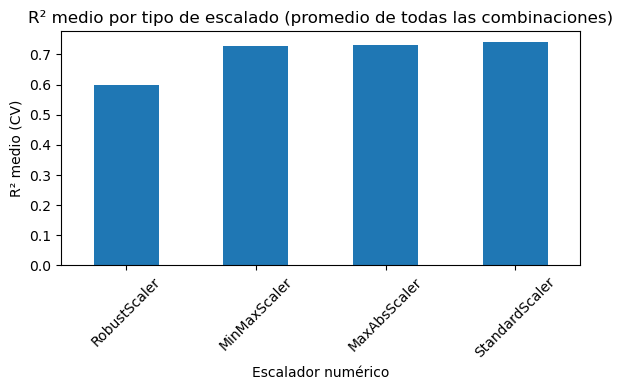

In [23]:
mean_by_scaler = results.groupby("num_scaler_name")["mean_test_score"].mean().sort_values()

plt.figure(figsize=(6, 4))
mean_by_scaler.plot(kind="bar")
plt.ylabel("R² medio (CV)")
plt.xlabel("Escalador numérico")
plt.title("R² medio por tipo de escalado (promedio de todas las combinaciones)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


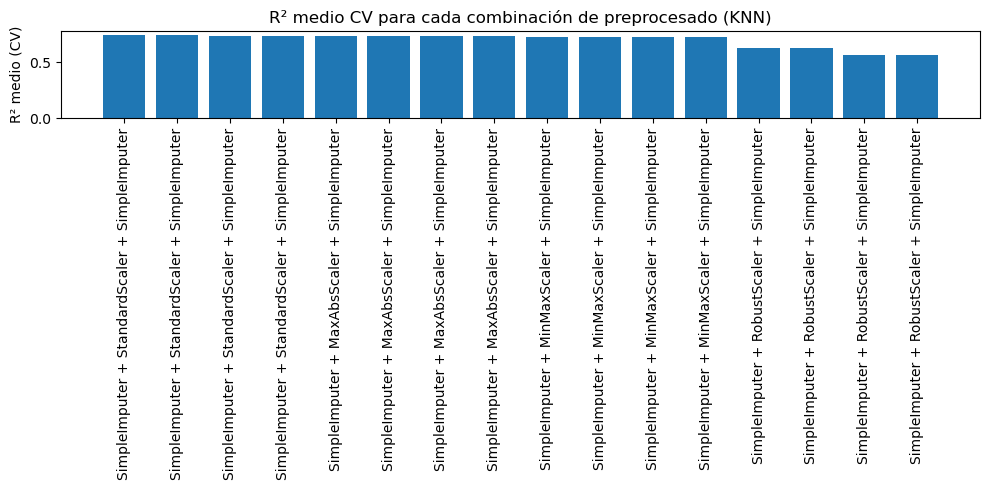

In [24]:
results_sorted = results.sort_values("mean_test_score", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(
    x=range(len(results_sorted)),
    height=results_sorted["mean_test_score"]
)

labels = (
    results_sorted["num_imputer_name"]
    + " + "
    + results_sorted["num_scaler_name"]
    + " + "
    + results_sorted["cat_imputer_name"]
)

plt.xticks(range(len(results_sorted)), labels, rotation=90)
plt.ylabel("R² medio (CV)")
plt.title("R² medio CV para cada combinación de preprocesado (KNN)")
plt.tight_layout()
plt.show()


In [25]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import pandas as pd

tscv = TimeSeriesSplit(n_splits=3)

def evaluar_modelo(nombre, modelo):
    """
    Ejecuta validación interna (TSCV con 6 años) + validación externa (años 7–9).
    Devuelve métricas + obj modelo entrenado.
    """

    # 1. Cross-validation temporal
    scores_cv = cross_val_score(
        modelo,
        X_train_6y_clean,
        y_train_6y,
        cv=tscv,
        scoring="r2",
        n_jobs=-1
    )

    # 2. Entrenamiento + predicción en validación externa
    modelo.fit(X_train_6y_clean, y_train_6y)
    y_pred_val = modelo.predict(X_val_3y_clean)

    r2_val = r2_score(y_val_3y, y_pred_val)
    mae_val = mean_absolute_error(y_val_3y, y_pred_val)

    return {
        "modelo": nombre,
        "r2_cv_mean": scores_cv.mean(),
        "r2_cv_std": scores_cv.std(),
        "r2_val": r2_val,
        "mae_val": mae_val
    }, modelo


In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

resultados_base = []
modelos_base_entrenados = {}

modelos_no_ens_base = {
    "KNN_base": KNeighborsRegressor(),
    "DecisionTree_base": DecisionTreeRegressor(random_state=42),
    "SVM_lineal_base": SVR(kernel="linear"),
    "SVM_rbf_base": SVR(kernel="rbf"),
}

for nombre, reg in modelos_no_ens_base.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor_final),
        ("regressor", reg)
    ])

    res, trained_model = evaluar_modelo(nombre, pipe)
    resultados_base.append(res)
    modelos_base_entrenados[nombre] = trained_model

df_base_no_ens = pd.DataFrame(resultados_base).sort_values("r2_val", ascending=False)
df_base_no_ens


,modelo,r2_cv_mean,r2_cv_std,r2_val,mae_val
0,KNN_base,0.740995,0.055292,0.809388,2.631987e+06
1,DecisionTree_base,0.606031,0.062610,0.698794,3.063838e+06
2,SVM_lineal_base,0.001245,0.001210,0.005660,7.046261e+06
3,SVM_rbf_base,-0.001774,0.002382,-0.000231,7.068971e+06


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import pandas as pd

# Definimos los grids de hiperparámetros para cada modelo
param_grids_no_ens = {
    "KNN": {
        "regressor__n_neighbors": [3, 5, 7, 10],
        "regressor__weights": ["uniform", "distance"]
    },
    "DecisionTree": {
        "regressor__max_depth": [3, 5, 10, None],
        "regressor__min_samples_split": [2, 5, 10]
    },
    "SVM_lineal": {
        "regressor__C": [0.01, 0.1, 1, 10, 100]
    },
    "SVM_rbf": {
        "regressor__C": [0.1, 1, 10, 100],
        "regressor__gamma": ["scale", 0.01, 0.1]
    }
}

resultados_no_ens_tuned = []
modelos_no_ens_tuned = {}

for nombre_corto, reg in [
    ("KNN", KNeighborsRegressor()),
    ("DecisionTree", DecisionTreeRegressor(random_state=42)),
    ("SVM_lineal", SVR(kernel="linear")),
    ("SVM_rbf", SVR(kernel="rbf"))
]:
    print(f"\n=== Ajustando {nombre_corto} ===")

    # Pipeline: mismo preprocesado + modelo concreto
    pipe = Pipeline([
        ("preprocessor", preprocessor_final),
        ("regressor", reg)
    ])

    # GridSearchCV con validación temporal
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids_no_ens[nombre_corto],
        cv=tscv,
        scoring="r2",
        n_jobs=-1
    )

    # Ajuste sobre los 6 primeros años
    grid.fit(X_train_6y_clean, y_train_6y)

    print("Mejores hiperparámetros:", grid.best_params_)

    best_model = grid.best_estimator_

    # Evaluación con nuestra función (CV interno + validación externa)
    res, tuned_model = evaluar_modelo(nombre_corto + "_tuned", best_model)
    resultados_no_ens_tuned.append(res)
    modelos_no_ens_tuned[nombre_corto] = tuned_model

# DataFrame con resultados, ordenado por R² en validación externa
df_no_ens_tuned = pd.DataFrame(resultados_no_ens_tuned).sort_values("r2_val", ascending=False)
df_no_ens_tuned



=== Ajustando KNN ===
Mejores hiperparámetros: {'regressor__n_neighbors': 10, 'regressor__weights': 'distance'}

=== Ajustando DecisionTree ===
Mejores hiperparámetros: {'regressor__max_depth': 3, 'regressor__min_samples_split': 2}

=== Ajustando SVM_lineal ===
Mejores hiperparámetros: {'regressor__C': 100}

=== Ajustando SVM_rbf ===
Mejores hiperparámetros: {'regressor__C': 100, 'regressor__gamma': 0.01}


,modelo,r2_cv_mean,r2_cv_std,r2_val,mae_val
0,KNN_tuned,0.757330,0.050610,0.824892,2.530309e+06
1,DecisionTree_tuned,0.734028,0.051405,0.800389,2.776461e+06
2,SVM_lineal_tuned,0.226762,0.077106,0.391689,5.355893e+06
3,SVM_rbf_tuned,0.000378,0.001455,0.003943,7.052145e+06


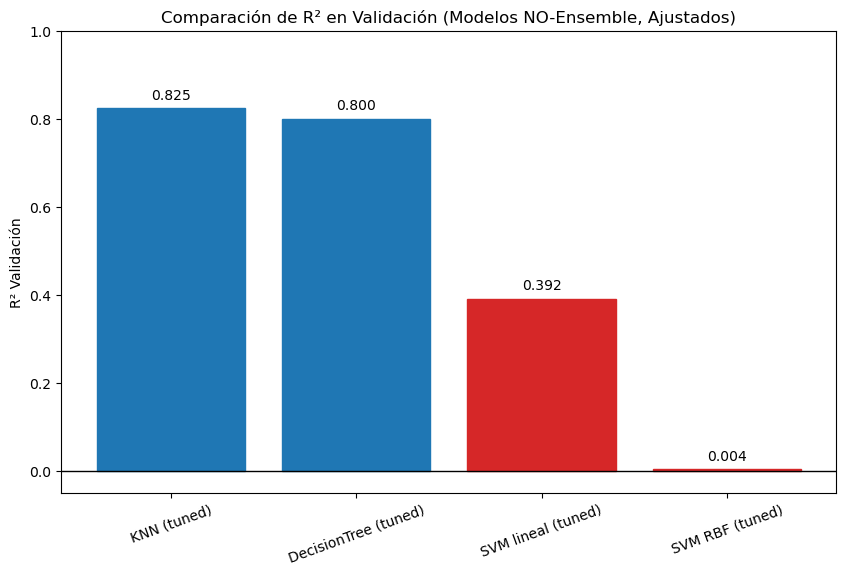

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Datos reales obtenidos (puedes añadir los modelos base si quieres)
modelos = [
    "KNN (tuned)", 
    "DecisionTree (tuned)", 
    "SVM lineal (tuned)", 
    "SVM RBF (tuned)"
]

r2_val = [
    0.824892,   # KNN tuned
    0.800389,   # Decision Tree tuned
    0.391689,   # SVM lineal tuned
    0.003943    # SVM RBF tuned
]

plt.figure(figsize=(10,6))
bars = plt.bar(modelos, r2_val)

# Colorear barras según rendimiento (opcional)
for b, val in zip(bars, r2_val):
    if val >= 0.75:
        b.set_color("tab:blue")
    elif val >= 0.4:
        b.set_color("tab:orange")
    else:
        b.set_color("tab:red")

plt.axhline(0, color="black", linewidth=1)
plt.ylabel("R² Validación")
plt.title("Comparación de R² en Validación (Modelos NO-Ensemble, Ajustados)")
plt.xticks(rotation=20)
plt.ylim(-0.05, 1)

for i, v in enumerate(r2_val):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.show()


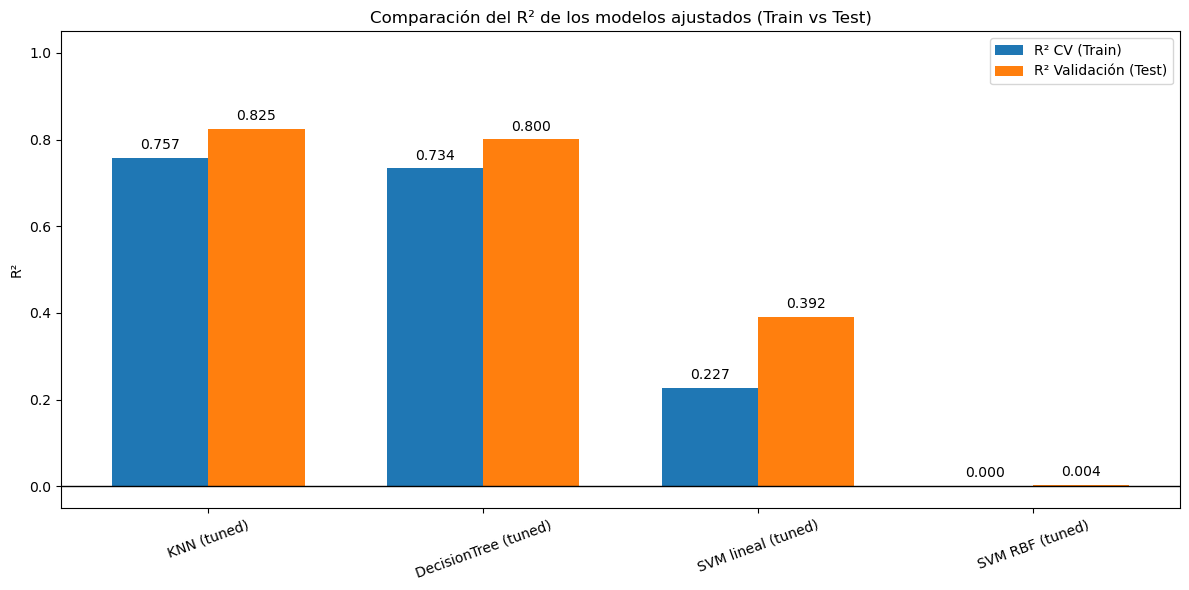

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de los modelos (tus modelos ajustados)
modelos = [
    "KNN (tuned)",
    "DecisionTree (tuned)",
    "SVM lineal (tuned)",
    "SVM RBF (tuned)"
]

# R² Train (CV mean)
r2_train = [
    0.757330,   # KNN
    0.734028,   # DT
    0.226762,   # SVM lin
    0.000378    # SVM rbf
]

# R² Validación externa
r2_test = [
    0.824892,   # KNN
    0.800389,   # DT
    0.391689,   # SVM lin
    0.003943    # SVM rbf
]

x = np.arange(len(modelos))
width = 0.35  # ancho de las barras

plt.figure(figsize=(12,6))
plt.bar(x - width/2, r2_train, width, label='R² CV (Train)')
plt.bar(x + width/2, r2_test, width, label='R² Validación (Test)')

plt.axhline(0, color="black", linewidth=1)
plt.ylabel("R²")
plt.title("Comparación del R² de los modelos ajustados (Train vs Test)")
plt.xticks(x, modelos, rotation=20)
plt.ylim(-0.05, 1.05)
plt.legend()

# Etiquetas numéricas encima de las barras
for i, v in enumerate(r2_train):
    plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center')
for i, v in enumerate(r2_test):
    plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()


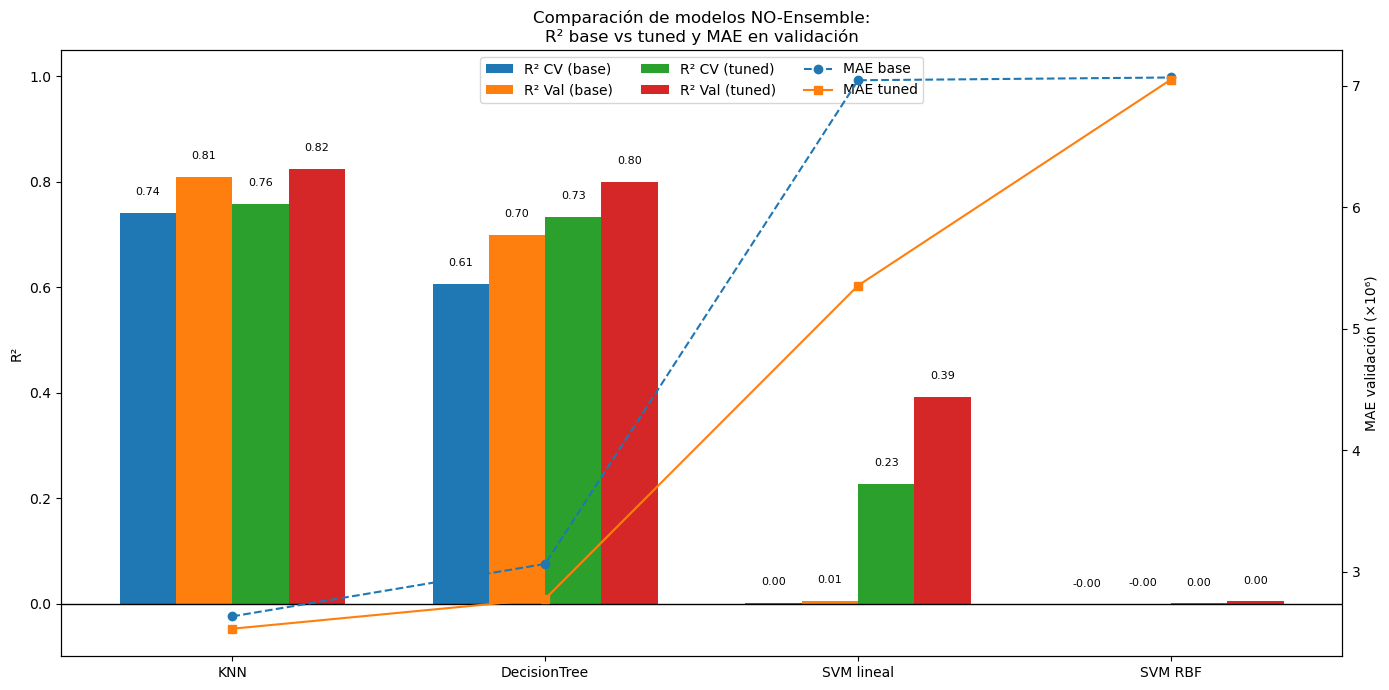

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# ===========================
# Datos (tus resultados reales)
# ===========================

modelos = ["KNN", "DecisionTree", "SVM lineal", "SVM RBF"]

# ---- R² CV (train) ----
r2_cv_base = [
    0.740995,   # KNN_base
    0.606031,   # DT_base
    0.001245,   # SVM_lin_base
    -0.001774   # SVM_rbf_base
]

r2_cv_tuned = [
    0.757330,   # KNN_tuned
    0.734028,   # DT_tuned
    0.226762,   # SVM_lin_tuned
    0.000378    # SVM_rbf_tuned
]

# ---- R² validación externa ----
r2_val_base = [
    0.809388,   # KNN_base
    0.698794,   # DT_base
    0.005660,   # SVM_lin_base
    -0.000231   # SVM_rbf_base
]

r2_val_tuned = [
    0.824892,   # KNN_tuned
    0.800389,   # DT_tuned
    0.391689,   # SVM_lin_tuned
    0.003943    # SVM_rbf_tuned
]

# ---- MAE validación (en millones) ----
mae_base = [
    2.631987,   # KNN_base
    3.063838,   # DT_base
    7.046261,   # SVM_lin_base
    7.068971    # SVM_rbf_base
]

mae_tuned = [
    2.530309,   # KNN_tuned
    2.776461,   # DT_tuned
    5.355893,   # SVM_lin_tuned
    7.052145    # SVM_rbf_tuned
]

# ===========================
# Gráfico
# ===========================

x = np.arange(len(modelos))
width = 0.18  # ancho de cada barra

fig, ax1 = plt.subplots(figsize=(14, 7))

# Barras de R² (4 por modelo)
b1 = ax1.bar(x - 1.5*width, r2_cv_base,  width, label='R² CV (base)')
b2 = ax1.bar(x - 0.5*width, r2_val_base, width, label='R² Val (base)')
b3 = ax1.bar(x + 0.5*width, r2_cv_tuned, width, label='R² CV (tuned)')
b4 = ax1.bar(x + 1.5*width, r2_val_tuned,width, label='R² Val (tuned)')

ax1.axhline(0, color="black", linewidth=1)
ax1.set_ylabel("R²")
ax1.set_title("Comparación de modelos NO-Ensemble:\nR² base vs tuned y MAE en validación")
ax1.set_xticks(x)
ax1.set_xticklabels(modelos)
ax1.set_ylim(-0.1, 1.05)

# Etiquetas numéricas encima de las barras
for bars in [b1, b2, b3, b4]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.03,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=8)

# Segundo eje Y para el MAE
ax2 = ax1.twinx()
ax2.set_ylabel("MAE validación (×10⁶)")

# Líneas de MAE (base vs tuned)
ax2.plot(x, mae_base, marker='o', linestyle='--', label='MAE base')
ax2.plot(x, mae_tuned, marker='s', linestyle='-',  label='MAE tuned')

# Leyendas combinadas
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', ncol=3)

plt.tight_layout()
plt.show()


In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

modelos_ens_base = {
    "RandomForest_base": RandomForestRegressor(random_state=42),
    "GradientBoosting_base": GradientBoostingRegressor(random_state=42)
}

resultados_ens_base = []
modelos_ens_base_guardados = {}

for nombre, modelo in modelos_ens_base.items():
    print(f"\n=== Evaluando {nombre} ===")

    pipe = Pipeline([
        ("preprocessor", preprocessor_final),
        ("regressor", modelo)
    ])

    res, modelo_entrenado = evaluar_modelo(nombre, pipe)

    resultados_ens_base.append(res)
    modelos_ens_base_guardados[nombre] = modelo_entrenado

df_ens_base = pd.DataFrame(resultados_ens_base).sort_values("r2_val", ascending=False)
df_ens_base



=== Evaluando RandomForest_base ===

=== Evaluando GradientBoosting_base ===


,modelo,r2_cv_mean,r2_cv_std,r2_val,mae_val
1,GradientBoosting_base,0.787272,0.046215,0.861652,2.173203e+06
0,RandomForest_base,0.784905,0.033212,0.856443,2.235311e+06


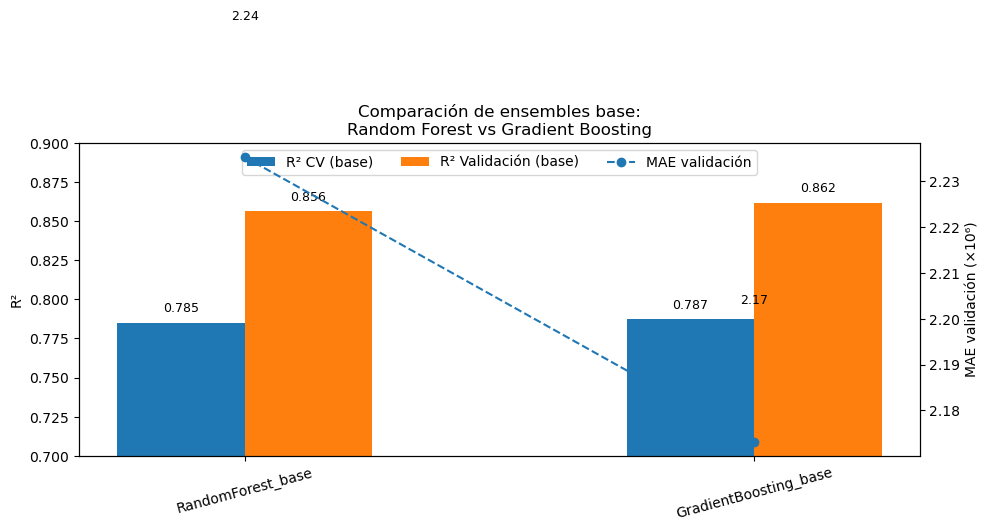

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de los modelos
modelos = ["RandomForest_base", "GradientBoosting_base"]

# R² CV (train) y R² Validación externa
r2_cv_mean = [0.784905, 0.787272]
r2_val     = [0.856443, 0.861652]

# MAE en validación (en millones para que sea más legible)
mae_val = [2.235311, 2.173203]

x = np.arange(len(modelos))
width = 0.25

fig, ax1 = plt.subplots(figsize=(10,6))

# Barras de R²
b1 = ax1.bar(x - width/2, r2_cv_mean, width, label="R² CV (base)")
b2 = ax1.bar(x + width/2, r2_val,     width, label="R² Validación (base)")

ax1.axhline(0, linewidth=1, color="black")
ax1.set_ylabel("R²")
ax1.set_title("Comparación de ensembles base:\nRandom Forest vs Gradient Boosting")
ax1.set_xticks(x)
ax1.set_xticklabels(modelos, rotation=15)
ax1.set_ylim(0.7, 0.9)

# Etiquetas numéricas encima de las barras
for bars in [b1, b2]:
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.005,
                 f"{h:.3f}", ha="center", va="bottom", fontsize=9)

# Segundo eje Y para el MAE
ax2 = ax1.twinx()
ax2.set_ylabel("MAE validación (×10⁶)")
ax2.plot(x, mae_val, marker="o", linestyle="--", label="MAE validación")

for i, v in enumerate(mae_val):
    ax2.text(i, v + 0.03, f"{v:.2f}", ha="center", fontsize=9)

# Leyenda combinada
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper center", ncol=3)

plt.tight_layout()
plt.show()


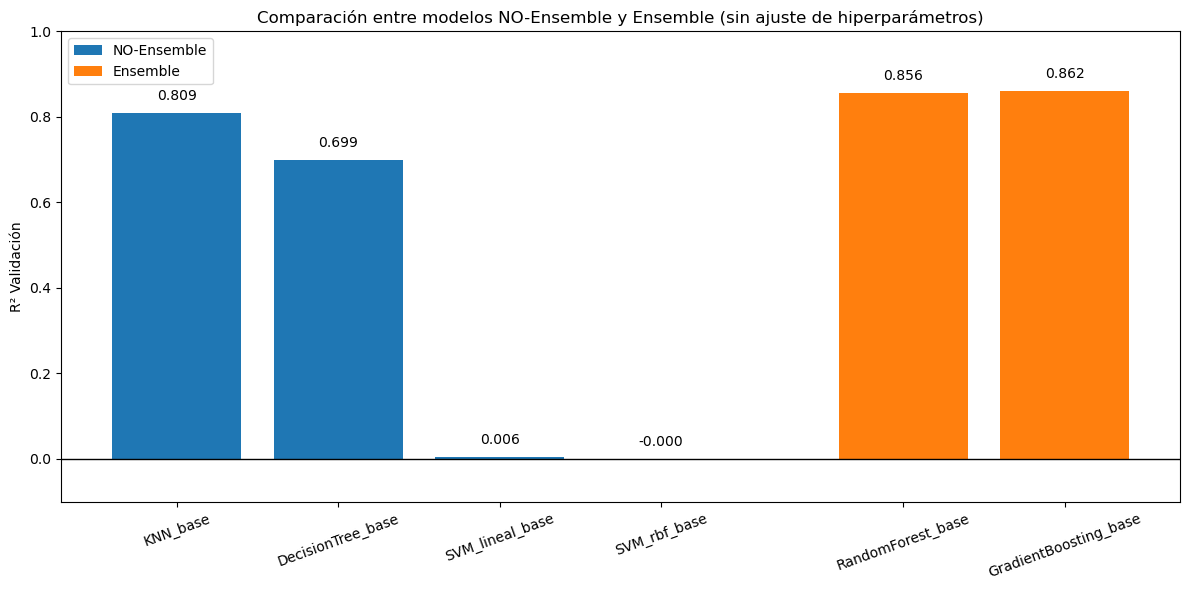

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Datos reales de tus modelos
# ============================

modelos_no = ["KNN_base", "DecisionTree_base", "SVM_lineal_base", "SVM_rbf_base"]
r2_no = [0.809388, 0.698794, 0.005660, -0.000231]

modelos_ens = ["RandomForest_base", "GradientBoosting_base"]
r2_ens = [0.856431, 0.861552]

# ============================
# Gráfico
# ============================

plt.figure(figsize=(12,6))

x_no = np.arange(len(modelos_no))
x_ens = np.arange(len(modelos_ens)) + len(modelos_no) + 0.5  # separación visual

# Barras
plt.bar(x_no, r2_no, color="tab:blue", label="NO-Ensemble")
plt.bar(x_ens, r2_ens, color="tab:orange", label="Ensemble")

# Eje X
plt.xticks(
    list(x_no) + list(x_ens),
    modelos_no + modelos_ens,
    rotation=20
)

plt.ylabel("R² Validación")
plt.title("Comparación entre modelos NO-Ensemble y Ensemble (sin ajuste de hiperparámetros)")
plt.axhline(0, color="black", linewidth=1)
plt.ylim(-0.1, 1.0)
plt.legend()

# Etiquetas numéricas
for x, v in zip(list(x_no) + list(x_ens), r2_no + r2_ens):
    plt.text(x, v + 0.03, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()


In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd

# ============================
# 1. Definir distribuciones de hiperparámetros
# ============================

# nº de predictores tras tu preprocesado (num + cat)
num_predictors = len(num_cols_clean) + len(cat_cols_clean)

# Random Forest
param_distributions_rf = {
    "regressor__n_estimators": np.arange(100, 1001, 100),   # 100, 200, ..., 1000
    "regressor__max_depth": [3, 5, 7],                      # profundidad moderada
    "regressor__max_features": [
        "sqrt",                                             # raíz de nº de predictores
        "log2",                                             # log2 de nº de predictores
        max(1, num_predictors // 3)                         # un tercio de predictores
    ]
}

# Gradient Boosting
param_distributions_gb = {
    "regressor__n_estimators": np.arange(100, 1001, 100),   # mismo rango que RF
    "regressor__learning_rate": [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.30],
    "regressor__max_depth": [3, 5, 7]
}

# ============================
# 2. RandomizedSearchCV para cada ensemble
# ============================

resultados_ens_tuned = []
modelos_ens_tuned = {}

for nombre_corto, modelo, dist in [
    ("RandomForest", RandomForestRegressor(random_state=42), param_distributions_rf),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42), param_distributions_gb)
]:
    print(f"\n=== Ajustando {nombre_corto} con RandomizedSearchCV ===")

    pipe = Pipeline([
        ("preprocessor", preprocessor_final),
        ("regressor", modelo)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=dist,
        n_iter=30,              # nº de combinaciones aleatorias a probar
        cv=tscv,                # validación temporal
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    # Ajuste sobre los 6 primeros años
    random_search.fit(X_train_6y_clean, y_train_6y)

    print("Mejores hiperparámetros:", random_search.best_params_)

    mejor_modelo = random_search.best_estimator_

    # Evaluación con nuestra función (CV interno + validación externa)
    res, modelo_entrenado = evaluar_modelo(nombre_corto + "_tuned", mejor_modelo)
    resultados_ens_tuned.append(res)
    modelos_ens_tuned[nombre_corto] = modelo_entrenado

# ============================
# 3. Tabla con resultados
# ============================

df_ens_tuned = pd.DataFrame(resultados_ens_tuned).sort_values("r2_val", ascending=False)
df_ens_tuned



=== Ajustando RandomForest con RandomizedSearchCV ===
Mejores hiperparámetros: {'regressor__n_estimators': np.int64(800), 'regressor__max_features': 'sqrt', 'regressor__max_depth': 7}

=== Ajustando GradientBoosting con RandomizedSearchCV ===
Mejores hiperparámetros: {'regressor__n_estimators': np.int64(100), 'regressor__max_depth': 3, 'regressor__learning_rate': 0.06}


,modelo,r2_cv_mean,r2_cv_std,r2_val,mae_val
1,GradientBoosting_tuned,0.790585,0.046167,0.859028,2.215506e+06
0,RandomForest_tuned,0.798619,0.032171,0.850057,2.346292e+06


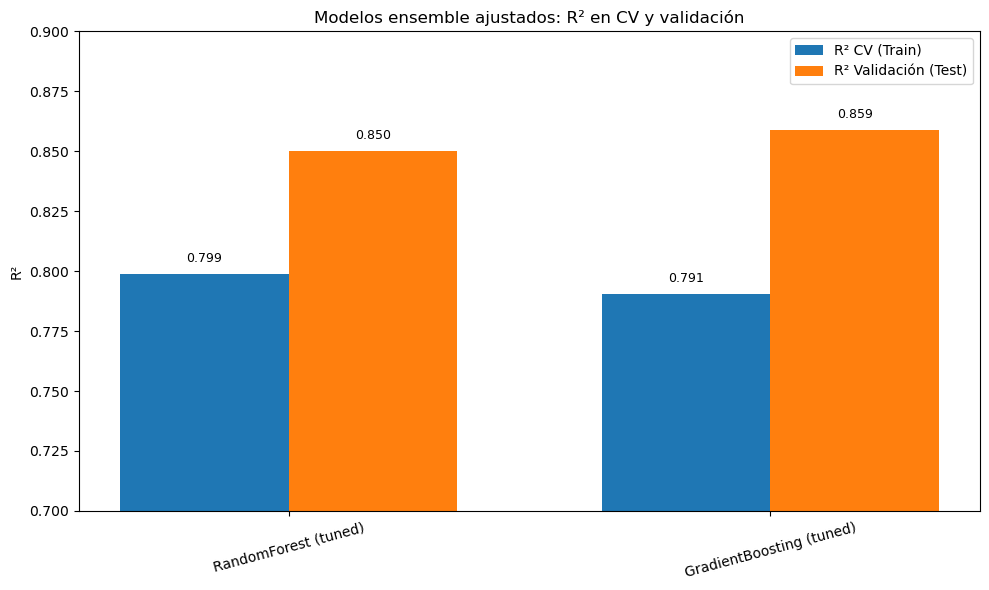

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Modelos
modelos = ["RandomForest (tuned)", "GradientBoosting (tuned)"]

# Tus datos (R² CV medio y R² validación externa)
r2_cv_tuned = [
    0.798619,  # RandomForest_tuned
    0.790585   # GradientBoosting_tuned
]

r2_val_tuned = [
    0.850057,  # RandomForest_tuned
    0.859028   # GradientBoosting_tuned
]

x = np.arange(len(modelos))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, r2_cv_tuned, width, label="R² CV (Train)")
plt.bar(x + width/2, r2_val_tuned, width, label="R² Validación (Test)")

plt.axhline(0, color="black", linewidth=1)
plt.xticks(x, modelos, rotation=15)
plt.ylabel("R²")
plt.ylim(0.7, 0.9)
plt.title("Modelos ensemble ajustados: R² en CV y validación")
plt.legend()

# Etiquetas numéricas
for i, v in enumerate(r2_cv_tuned):
    plt.text(i - width/2, v + 0.005, f"{v:.3f}", ha="center", fontsize=9)
for i, v in enumerate(r2_val_tuned):
    plt.text(i + width/2, v + 0.005, f"{v:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


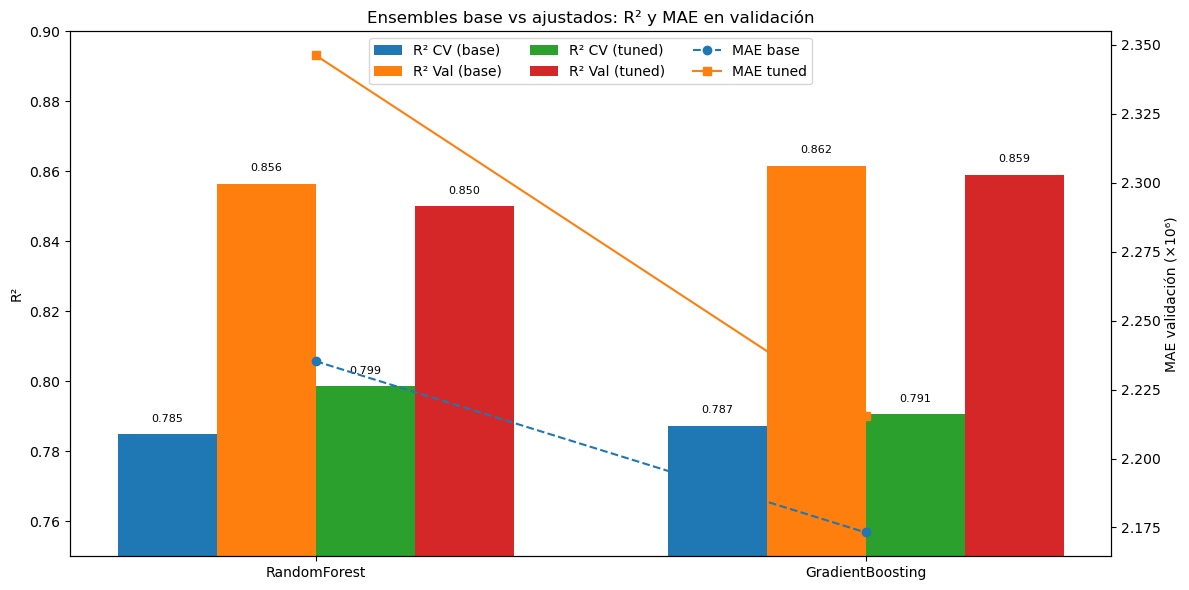

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# ===========================
# Datos (tus resultados)
# ===========================

modelos = ["RandomForest", "GradientBoosting"]

# R² CV (base y tuned)
r2_cv_base = [
    0.784905,  # RF_base
    0.787272   # GB_base
]

r2_cv_tuned = [
    0.798619,  # RF_tuned
    0.790585   # GB_tuned
]

# R² validación (base y tuned)
r2_val_base = [
    0.856443,  # RF_base
    0.861652   # GB_base
]

r2_val_tuned = [
    0.850057,  # RF_tuned
    0.859028   # GB_tuned
]

# MAE validación (en millones)
mae_base = [
    2.235311,  # RF_base
    2.173203   # GB_base
]

mae_tuned = [
    2.346292,  # RF_tuned
    2.215506   # GB_tuned
]

# ===========================
# Gráfico
# ===========================

x = np.arange(len(modelos))
width = 0.18

fig, ax1 = plt.subplots(figsize=(12, 6))

b1 = ax1.bar(x - 1.5*width, r2_cv_base,  width, label="R² CV (base)")
b2 = ax1.bar(x - 0.5*width, r2_val_base, width, label="R² Val (base)")
b3 = ax1.bar(x + 0.5*width, r2_cv_tuned, width, label="R² CV (tuned)")
b4 = ax1.bar(x + 1.5*width, r2_val_tuned,width, label="R² Val (tuned)")

ax1.set_ylabel("R²")
ax1.set_title("Ensembles base vs ajustados: R² y MAE en validación")
ax1.set_xticks(x)
ax1.set_xticklabels(modelos)
ax1.set_ylim(0.75, 0.9)
ax1.axhline(0, color="black", linewidth=1)

# Etiquetas en barras
for bars in [b1, b2, b3, b4]:
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.003,
                 f"{h:.3f}", ha="center", va="bottom", fontsize=8)

# Segundo eje para MAE
ax2 = ax1.twinx()
ax2.set_ylabel("MAE validación (×10⁶)")

ax2.plot(x, mae_base, marker="o", linestyle="--", label="MAE base")
ax2.plot(x, mae_tuned, marker="s", linestyle="-",  label="MAE tuned")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper center", ncol=3)

plt.tight_layout()
plt.show()
